In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.23273563385009766
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.15317438266895436
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.15547720591227213
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.15039021880538375
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.1567636595831977


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.6054484  0.38179696 0.01275463]
[0. 1. 0.] <-> [0.41459692 0.58281463 0.00258845]
[0. 1. 0.] <-> [5.5139981e-02 9.4442558e-01 4.3445805e-04]
[0. 0. 1.] <-> [0.07985878 0.0060246  0.9141166 ]
[0. 0. 1.] <-> [0.20039399 0.00924115 0.79036486]
[0. 0. 1.] <-> [0.0694315  0.00507685 0.92549163]
[1. 0. 0.] <-> [0.9731598  0.01429304 0.0125471 ]
[1. 0. 0.] <-> [0.9679116  0.02915537 0.00293302]
[1. 0. 0.] <-> [0.91606593 0.01653443 0.0673997 ]
[1. 0. 0.] <-> [0.9574994  0.03136031 0.01114033]
[1. 0. 0.] <-> [0.9323816  0.06190176 0.00571675]
[1. 0. 0.] <-> [0.4037131  0.58922607 0.00706077]
[1. 0. 0.] <-> [0.9636564  0.03210983 0.00423382]
[1. 0. 0.] <-> [0.9353373  0.01737463 0.0472881 ]
[1. 0. 0.] <-> [0.93732226 0.02237382 0.04030387]
[0. 1. 0.] <-> [6.881046e-02 9.303212e-01 8.682557e-04]
[1. 0. 0.] <-> [0.96405786 0.02948821 0.00645399]
[1. 0. 0.] <-> [0.9216614  0.07289416 0.00544439]
[1. 0. 0.] <-> [0.96258163 0.03275956 0.00465879]
[1. 0. 0.] <-> [0.9532954  0.033560

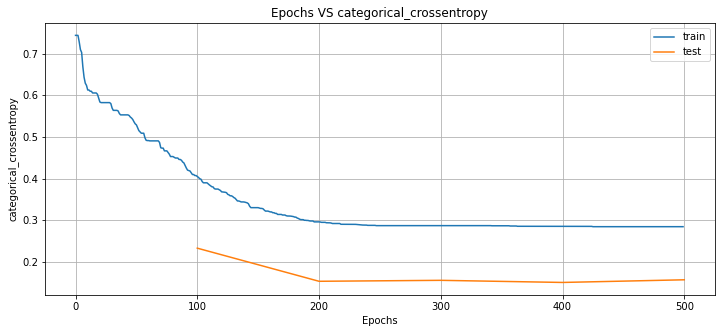

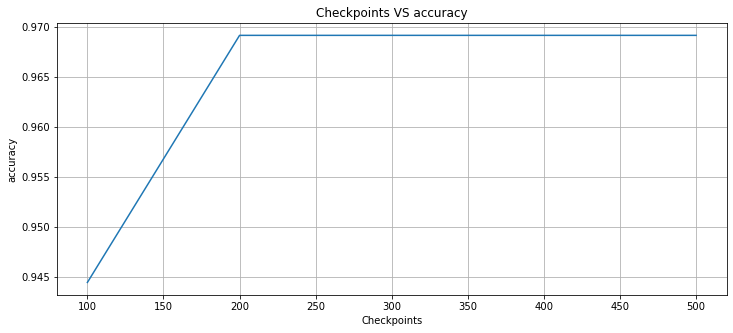

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.12263113007328459, 'categorical_crossentropy': 0.23273563385009766, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 7, 'tn_hit': 23, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 3}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.0738934971550398, 'categorical_crossentropy': 0.15317438266895436, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 2, 'tn_hit': 28, 'fn_hit': 3}, 1: {'tp_hit': 16, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 0}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.07365973608101352, 'categorical_crossentropy': 0.15547720591227213, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 2, 'tn_hit': 28, 'fn_hit': 3}, 1: {'tp_hit': 16, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 0}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.6550076e+00  2.3658960e+00  2.5574403e+00  2.1785749e-02
  8.8287407e-04]
 bias: -1.6583435535430908

Neuron 1: weights:
[-0.00163744  1.3147635  -0.01389234 -0.09797885 -0.37181744]
 bias: 0.018475951626896858

Neuron 2: weights:
[-0.05694296  1.8807254  -0.11503034 -0.4747356  -2.1967456 ]
 bias: 1.5762898921966553

Neuron 3: weights:
[ 0.2696665  -1.2698159   0.00562546  0.11747938  0.48922917]
 bias: 0.039954397827386856

$
Layer 2
Neuron 0: weights:
[-3.          0.08336208  3.          0.05397699]
 bias: -0.017536083236336708

Neuron 1: weights:
[ 3.         0.7410799 -0.2270536 -2.0169315]
 bias: -0.5868306756019592

Neuron 2: weights:
[ 0.01657035 -1.8790923  -3.          3.        ]
 bias: 0.04235305264592171

$

